Prediction vs Actual Results:
      Date                  Match Actual Result Logistic Regression Prediction SVM Prediction Random Forest Prediction
23/09/2012    Man City vs Arsenal          Draw                       Home Win           Draw                     Draw
03/11/2012  Man United vs Arsenal      Home Win                       Away Win       Away Win                 Home Win
20/10/2012     Norwich vs Arsenal      Home Win                       Away Win       Away Win                 Away Win
24/03/2012 Arsenal vs Aston Villa      Home Win                       Home Win       Home Win                 Home Win
06/10/2012    West Ham vs Arsenal      Away Win                       Away Win       Away Win                 Away Win

Logistic Regression Accuracy: 0.40
Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.33      1.00      0.50         1
           0       0.00      0.00      0.00         1
           1  

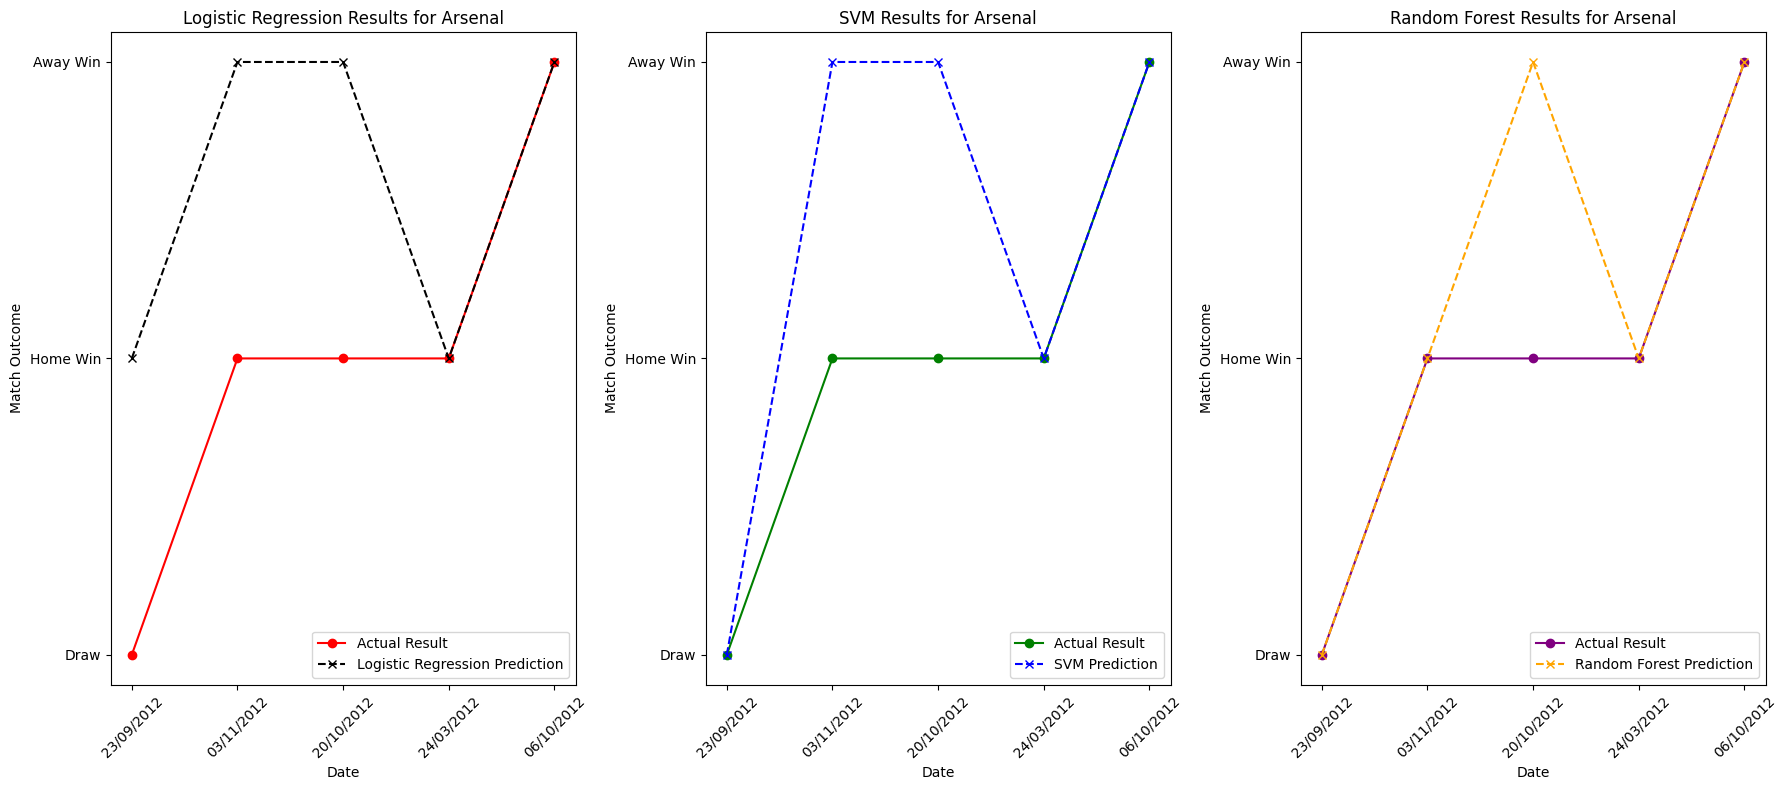

In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Parameters for customization
team_name = 'Arsenal'
year = 2012

# Load the dataset
file_path = '/content/drive/MyDrive/EPL/final_dataset (10-15).xlsx'
df = pd.read_excel(file_path)

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the specified team and year
team_matches = df[((df['HomeTeam'] == team_name) | (df['AwayTeam'] == team_name)) & (df['Date'].dt.year == year)]

# Check if there are at least 15 matches (10 for training, 5 for testing)
if len(team_matches) < 15:
    raise ValueError(f"Not enough matches found for {team_name} in {year}. At least 15 matches are required.")

# Sort by date
team_matches = team_matches.sort_values(by='Date')

# Prepare the features and target variable
team_matches['FTR'] = team_matches['FTR'].map({'H': 1, 'A': -1, 'D': 0})
team_matches['RecentForm'] = team_matches['FTHG'] - team_matches['FTAG']

# Add new features: Home Shots (HS), Away Shots (AS), Home Shots on Target (HST), Away Shots on Target (AST)
features = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'RecentForm', 'HS', 'AS', 'HST', 'AST']
for feature in features:
    if feature not in team_matches.columns:
        raise ValueError(f"Feature '{feature}' not found in the dataset.")

# Prepare the feature matrix X and target vector y
X = team_matches[features]
y = team_matches['FTR']

# Standardize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Use the first 10 matches for training
X_train = X[:10]
y_train = y[:10]

# Randomly select 5 matches from the remaining matches for testing
remaining_matches = X[10:]
y_remaining = y[10:]

random_indices = np.random.choice(range(len(remaining_matches)), size=5, replace=False)
X_test = remaining_matches[random_indices]
y_test = y_remaining.iloc[random_indices]

# Initialize and train Logistic Regression model with increased max_iter
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)
log_reg.fit(X_train, y_train)

# Initialize and train Support Vector Machine model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Initialize and train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions with all models
y_pred_log_reg = log_reg.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Get match details for test data
test_matches = team_matches.iloc[10:].reset_index(drop=True).iloc[random_indices]

# Display predictions vs actual results for all models
results = pd.DataFrame({
    'Date': test_matches['Date'].dt.strftime('%d/%m/%Y'),
    'Match': test_matches['HomeTeam'] + ' vs ' + test_matches['AwayTeam'],
    'Actual Result': y_test.map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'}).values,
    'Logistic Regression Prediction': pd.Series(y_pred_log_reg).map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'}).values,
    'SVM Prediction': pd.Series(y_pred_svm).map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'}).values,
    'Random Forest Prediction': pd.Series(y_pred_rf).map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'}).values
})

print("Prediction vs Actual Results:")
print(results.to_string(index=False))

# Evaluate the Logistic Regression model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'\nLogistic Regression Accuracy: {accuracy_log_reg:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'\nSVM Accuracy: {accuracy_svm:.2f}')
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'\nRandom Forest Accuracy: {accuracy_rf:.2f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Plot Actual vs Predicted Results for all models
plt.figure(figsize=(18, 8))

# Plot for Logistic Regression
plt.subplot(1, 3, 1)
plt.plot(results['Date'], results['Actual Result'], marker='o', linestyle='-', color='red', label='Actual Result')
plt.plot(results['Date'], results['Logistic Regression Prediction'], marker='x', linestyle='--', color='black', label='Logistic Regression Prediction')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Match Outcome')
plt.title(f'Logistic Regression Results for {team_name}')
plt.legend()

# Plot for SVM
plt.subplot(1, 3, 2)
plt.plot(results['Date'], results['Actual Result'], marker='o', linestyle='-', color='green', label='Actual Result')
plt.plot(results['Date'], results['SVM Prediction'], marker='x', linestyle='--', color='blue', label='SVM Prediction')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Match Outcome')
plt.title(f'SVM Results for {team_name}')
plt.legend()

# Plot for Random Forest
plt.subplot(1, 3, 3)
plt.plot(results['Date'], results['Actual Result'], marker='o', linestyle='-', color='purple', label='Actual Result')
plt.plot(results['Date'], results['Random Forest Prediction'], marker='x', linestyle='--', color='orange', label='Random Forest Prediction')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Match Outcome')
plt.title(f'Random Forest Results for {team_name}')
plt.legend()

plt.tight_layout()
plt.show()
